<a href="https://colab.research.google.com/github/vlad-danaila/machine-learning-workout/blob/master/Exercise_6_FCN_Torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Fully connected Network**

In [1]:
!pip install torch

In [0]:
import numpy as np
import sklearn as sk
import sklearn.datasets
import sklearn.model_selection
import matplotlib.pyplot as plt
import torch as t

**Loading data**

In [0]:
def normalize(x):
  x_max, x_min = max(x), min(x)
  return (x - x_min) / (x_max - x_min)

In [0]:
x, _ = sk.datasets.make_regression(n_samples = 1000, n_features=2, n_informative=2, n_targets=1)
y = np.sin(x[:, 0] * 4)

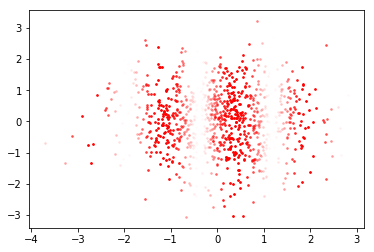

In [17]:
def plot_points(x, y):
  z = normalize(y)
  for i in range(len(x)):
    plt.scatter(x[i, 0], x[i, 1], color = 'red', alpha = z[i], s = 3)

plot_points(x, y)
plt.show()

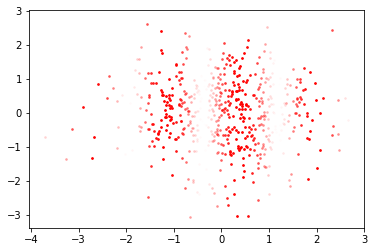

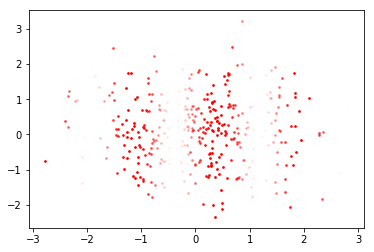

In [18]:
x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(x, y, test_size = .4)

plot_points(x_train, y_train)
plt.show()
plot_points(x_test, y_test)
plt.show()

In [0]:
class PointsSet(t.utils.data.Dataset):
  def __init__(self, x, y):
#     self.x = x.astype(np.float32)
#     self.y = y.astype(np.float32)
    self.x = t.tensor(x, dtype = t.float32, device = 'cuda:0')
    self.y = t.tensor(y, dtype = t.float32, device = 'cuda:0')
    self.len = len(y)
  
  def __getitem__(self, i):
    return self.x[i], self.y[i]
  
  def __len__(self):
    return self.len

In [0]:
loader_train = t.utils.data.DataLoader(PointsSet(x_train, y_train), batch_size = 50, shuffle = True)
loader_test = t.utils.data.DataLoader(PointsSet(x_test, y_test), batch_size = len(y_test), shuffle = False)

**Define Model**

In [0]:
class Regressor(t.nn.Module):
  def __init__(self):
    super().__init__()
    self.fc_1 = t.nn.Linear(2, 4)
    self.fc_2 = t.nn.Linear(4, 8)
    self.fc_3 = t.nn.Linear(8, 1)
 
  def forward(self, x):
    x = t.sigmoid(self.fc_1(x))
    x = t.sigmoid(self.fc_2(x))
    x = self.fc_3(x)
    return x

**Train**

In [22]:
model = Regressor().cuda()
optimizer = t.optim.Adam(model.parameters(), lr = 1e-2)
loss_fn = t.nn.MSELoss()
epochs = 1500

loss_train, loss_test = [], []

for epoch in range(epochs):
  # Train
  epoch_train_loss = 0
  for _x, _y in loader_train:
    y_pred = model.forward(_x)
    y_pred = y_pred.reshape(-1)
    loss = loss_fn(y_pred, _y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    epoch_train_loss += loss.item()
  epoch_train_loss /= len(loader_train)
  loss_train.append(epoch_train_loss)
  # Test
  _x, _y = next(iter(loader_test))
  y_pred = model.forward(_x)
  y_pred = y_pred.reshape(-1)
  epoch_test_loss = loss_fn(y_pred, _y)
  loss_test.append(epoch_test_loss.item())
  print('Epoch {} train loss {} test loss {}'.format(epoch + 1, epoch_train_loss, epoch_test_loss))

Epoch 1 train loss 0.7452795306841532 test loss 0.5319250822067261
Epoch 2 train loss 0.4924623395005862 test loss 0.5153225064277649
Epoch 3 train loss 0.5024017269412676 test loss 0.5004339814186096
Epoch 4 train loss 0.48530307908852893 test loss 0.5105432868003845
Epoch 5 train loss 0.48639825731515884 test loss 0.5056217312812805
Epoch 6 train loss 0.4878251602252324 test loss 0.5009357333183289
Epoch 7 train loss 0.48468297719955444 test loss 0.5055748224258423
Epoch 8 train loss 0.4856448049346606 test loss 0.5025414824485779
Epoch 9 train loss 0.4849529241522153 test loss 0.5047464966773987
Epoch 10 train loss 0.4863302906354268 test loss 0.5027487874031067
Epoch 11 train loss 0.48468125859896344 test loss 0.5043759942054749
Epoch 12 train loss 0.4851755624016126 test loss 0.5026463866233826
Epoch 13 train loss 0.48492436359326047 test loss 0.5026347637176514
Epoch 14 train loss 0.4873977725704511 test loss 0.5017984509468079
Epoch 15 train loss 0.48386767009894055 test loss 0.

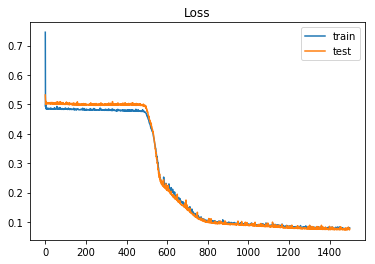

In [23]:
plt.plot(range(len(loss_train)), loss_train, label = 'train')
plt.plot(range(len(loss_test)), loss_test, label = 'test')
plt.legend()
plt.title('Loss')
plt.show()

In [0]:
def make_grid(x, steps = 1000):
  x_min, x_max = min(x), max(x)
  diff = x_max - x_min
  padd = diff / 10
  return np.linspace(x_min - padd, x_max + padd, steps)

def to_numpy(x):
  return x.cpu().detach().numpy()

In [0]:
x0, x1 = make_grid(x[:, 0]), make_grid(x[:, 1])
mesh_x0, mesh_x1 = np.meshgrid(x0, x1)
x01 = np.c_[mesh_x0.ravel(), mesh_x1.ravel()]
y_grid = model.forward(t.tensor(x01, device = 'cuda:0', dtype = t.float32))
y_grid = to_numpy(y_grid).reshape(mesh_x0.shape)

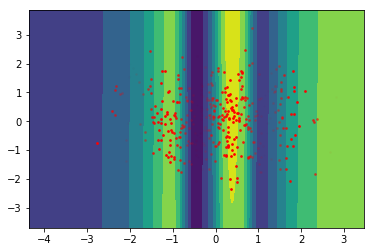

In [26]:
plt.contourf(x0, x1, y_grid)
plot_points(x_test, y_test)
plt.show()